In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

import pandas as pd
import numpy as np


import json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### 读取数据集

In [11]:

df = pd.read_csv('医疗费用预测insurance.csv')
with open("insuranceCfg.json", "r", encoding="utf-8") as f:
        cfg = json.load(f)
print("cfg:",cfg)

#编码
df['sex'] = df['sex'].map({'female':0,'male':1})  
df['smoker'] = df['smoker'].map({'no':0,'yes':1})
df['region'] = df['region'].map({'northeast':0,'northwest':1,'southeast':2,'southwest':3})


features = df.iloc[:, :-1] # 特征
features = torch.tensor(features.values,dtype=torch.float32)

labels = df.iloc[:,-1]  # 标签
labels = torch.tensor(labels,dtype=torch.float32)


#归一化
# 特征和标签归一化
features_tensor = torch.tensor(df.iloc[:, :-1].values, dtype=torch.float32)
labels_tensor = torch.tensor(df.iloc[:, -1].values, dtype=torch.float32)

# 计算归一化参数
feature_min = features_tensor.min(dim=0).values
feature_max = features_tensor.max(dim=0).values
label_min = labels_tensor.min()
label_max = labels_tensor.max()

# 应用归一化
features = (features_tensor - feature_min) / (feature_max - feature_min + 1e-8)
labels = (labels_tensor - label_min) / (label_max - label_min + 1e-8)
labels = labels.view(-1, 1)  # 确保形状为 [n_samples, 1]


class insuranceDataset(Dataset):

    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
batch_Size = int(cfg['batch_Size'])  #32


dataset = insuranceDataset(features, labels)
train_loader = DataLoader(dataset, batch_size=batch_Size, shuffle=True)





cfg: {'batch_Size': '32', 'epochs': '300', 'lr': '0.001', 'input_size': '6', 'hidden_size': '16', 'output_size': '1', 'patience': '20'}


### 模型搭建

In [12]:
class insuranceModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(insuranceModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
    


### 训练

In [ ]:
input_size, hidden_size, output_size = int(cfg['input_size']), int(cfg['hidden_size']), int(cfg['output_size'])
model = insuranceModel(input_size, hidden_size, output_size).to(device)  # input_size=6, hidden_size=4, output_size=1
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=float(cfg['lr']))


# 初始化记录
train_loss_history = []
best_loss = float('inf')


patience = int(cfg["patience"])  # 容忍多少个epoch无提升
counter = 0


for epoch in range(int(cfg['epochs'])):
    epoch_loss = 0.0
    model.train()
    
    for i, (features, labels) in enumerate(train_loader):
        features = features.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
        if (i+1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                epoch+1, cfg['epochs'], i+1, len(train_loader), loss.item()))
    
    avg_loss = epoch_loss / len(train_loader)
    train_loss_history.append(avg_loss)
    

    # 保存最佳模型
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'loss': avg_loss
        }, 'best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break
    
    # 打印每个epoch的平均损失
    print(f'Epoch {epoch+1} Average Loss: {avg_loss:.4f}')

print('Finished Training!')

Epoch [1/300], Step [10/42], Loss: 0.1099
Epoch [1/300], Step [20/42], Loss: 0.0761
Epoch [1/300], Step [30/42], Loss: 0.0677
Epoch [1/300], Step [40/42], Loss: 0.0426
Epoch 1 Average Loss: 0.0781
Epoch [2/300], Step [10/42], Loss: 0.0222
Epoch [2/300], Step [20/42], Loss: 0.0232
Epoch [2/300], Step [30/42], Loss: 0.0141
Epoch [2/300], Step [40/42], Loss: 0.0104
Epoch 2 Average Loss: 0.0197
Epoch [3/300], Step [10/42], Loss: 0.0192
Epoch [3/300], Step [20/42], Loss: 0.0207
Epoch [3/300], Step [30/42], Loss: 0.0201
Epoch [3/300], Step [40/42], Loss: 0.0151
Epoch 3 Average Loss: 0.0135
Epoch [4/300], Step [10/42], Loss: 0.0157
Epoch [4/300], Step [20/42], Loss: 0.0119
Epoch [4/300], Step [30/42], Loss: 0.0080
Epoch [4/300], Step [40/42], Loss: 0.0094
Epoch 4 Average Loss: 0.0113
Epoch [5/300], Step [10/42], Loss: 0.0092
Epoch [5/300], Step [20/42], Loss: 0.0053
Epoch [5/300], Step [30/42], Loss: 0.0090
Epoch [5/300], Step [40/42], Loss: 0.0048
Epoch 5 Average Loss: 0.0097
Epoch [6/300], 

### 训练过程可视化

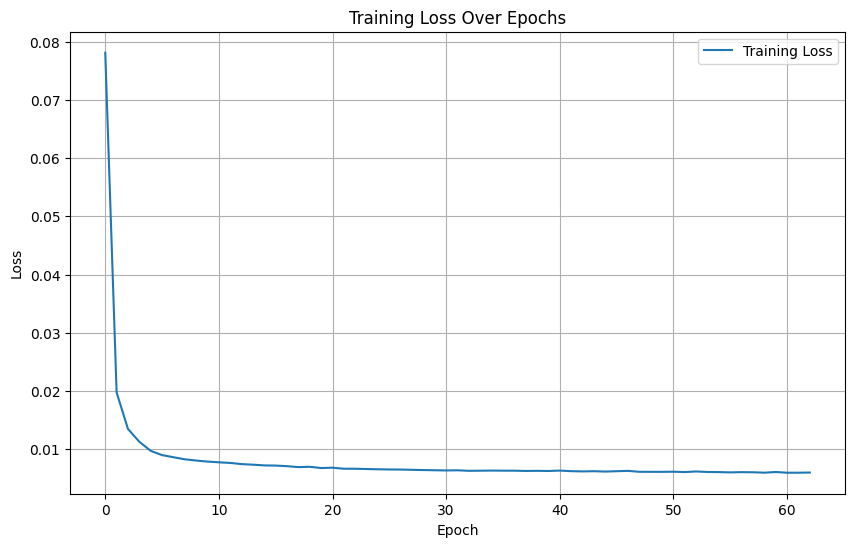

In [14]:
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('training_loss.png')